# TP-6 Texture synthesis

### Student information
Student: Balthazar Neveu

🔗 [Github](https://github.com/balthazarneveu/MVA24-delire) | [Online page for this class lab session](https://balthazarneveu.github.io/MVA24-delire)

⭐ [Online HTML version of this notebook](https://balthazarneveu.github.io/MVA24-delire/TP_6/tp_6.html) - good for animations!

# Gatys texture synthesis
### Question 1
`'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1` describe the activations outputs chosen to generate the given texture. The output of the ReLU unit inside the VGG network is used:  $\text{conv\_l\_i}$ define:
- the layer $l$ 
- the convolution depth $i$ inside layer $l$. 

> Layer $l$ indicates the amount of pooling ($l=1$ no pooling, $l=2 mean 1 average pooling has been performed, original width and height have been  divided by a factor of 2.)


|Original | Generated with chosen layers conv $(5,1), (5,1), (4,1),(3,1), (2,1), (1,1)$  |
| :---: | :---: |
|![](figures/texture_original.png) | ![](figures/texture_conv_5_4_3_2_1.png) |

### Question 2
We can test several layers to generate textures to visualize the patterns hierarchy.
We can observe that:
- the most shallow layer $l=1$ roughly gets the colors right .
- shallow depths ($l=1$ or $l=2$) lead to fine grained texture (like rough surface).
- Deeper layers correspond to higher level objects definitions... but please note that optimizing on `conv_5_1` didn't lead to realistic textures.

Therefore texture generation by performing optimization at several layers is a relevant idea to generate realistic textures.

![](figures/texture_synthesis_comparisons.png)



#### Question 3
The [`Adam` optimizer](https://arxiv.org/pdf/1412.6980.pdf) is used here instead of L-BFGS (although the L stands for limited and is a quasi netwon). Newton method requires the Hessian (the matrix of partial second derivatives of the loss with regard to the input color levels... which without any approximation will be a $(3*256^2)^2=154.6\text{Gb}$ stored as float32)... We clearly understand why keeping track of gradients (and momentums) occupies much less memory... 

In [8]:
print(f"Hessian {(3*256**2)**2/(1E9)*4:.2f} GB , Adam ~ 3x {(3*256**2)/(1E6)*4:.2f}MB")

Hessian 154.62 GB , Adam ~ 3x 0.79MB


# TextureNet


⭐ [ANIMATIONS BETTER VIEWED Online HTML version of this notebook](https://balthazarneveu.github.io/MVA24-delire/TP_6/tp_6.html)

![](figures/texture_net_more_samples.png)

#### Question 1: Overfitting
- "Collapse" : A trivial solution that the network could learn is to directly output the original image, no matter the input noise vector...(sometimes called mode collapse). The loss would become 0.
- Another trickier case of overfiting it that the network outputs the original image with geometric transformations which preserves feature maps invariance with regard to covariance (neglecting border effects, channel covariances / Gramm Matrices would remain invariant)... which basically **mean translations**! if you rotate or scale the image, you won't get exactly the same feature maps... (but CNN are translation equivariant).

#### Question 2: Architecture
When VGG has millions of parameters, the TextureNet architecture is actually much smaller and contains only a lightweight **116k parameters**.
It is a pyramidal architecture with 5 scales which will progressively:
- start from a low resolution noise image with 3 channels
- perform a stack of convolutions with a hidden dimension of 8 channels followed by non linear activation ReLU 
  -  2x convolutions of size 3x3  (*and increase the amount of channels*) 
  -  1x pointwise (conv 1x1) convolution (=mix channels).
- end up with a a feature map:
  - which will be upscaled (nearest neighbor=repeat pixels)
  - and concatenated with the higher resolution generated feature map. 
  - Note: every scale merge induces adding 8 channels.
- Add another convolution stack to process the merged feature maps, the number of channels is increased by eight channels.
- Since as we increase the resoltion we also increase the amount of channels, there's a final pointwise conv1x1 to switch from 40 channels to 3 color channels.

#### Question 3: Examples of TextureNet
Pretty impressive examples for various networks learnt on several texture sets (1 image generated = 1 network specifically learnt on 1 texture image).

![](figures/texture_net_samples.png)

If we take a closer look at lego and marble textures versus the real texture, we can see that it is difficult for the network to preserve lower resolution structures (large geometric structures like lego squares) which may not be considered as part of the "style" (or simply the convnet architecture does not have wide enough receptive field).

![](figures/texture_net_not_so_good.png)

#### Question 4 / 5 : Interpolation



|![](figures/texture_net_video.gif) | ![](figures/texture_net_video_lego.gif) |
|:---: | :----: |

It looks like the image in the middle of the 2 interpolations... is simply another texture (almost unrelated to the first and last images).

#### Question 6 `Redresse`
Applying a transfer function to a uniform noise probability allows changing the noise distribution from a uniform distribution to a more peaky distribution.
We could morph a given noise instance from the uniform distribution into another instance of the uniform distribution by passing through a peaky distribution to get a texture nearly "spatially uniform" (look at the all gray homogenous soap bubbles in the middle of the video when we use the redresse function!).
 
![](figures/distribution_change_redresse.png)


| First | Middle with `redresse` | Last |
|:---:|:---:|:---:|
|![](figures/texture_net_redresse_first.png) | ![](figures/texture_net_redresse_middel.png) | ![](figures/texture_net_redresse_last.png) |   

![](figures/texture_net_video_redresse_2.gif)

-----

#### Appendix / personal notes

- Pyramid Architecture from Texture Net
![](figures/texture_net_architecture.png)

- Training method for texture Net:
  - Transfer the knowledge of texture synthesis process to a small generator CNN.
  - The texture synthesis process is the one we saw from Gatys in the first section and works by optimizing over an input image to minimize the Froebenius distance between the Gram matrices of the generated image the ) 
![](figures/texture_net_training_architecture.png)

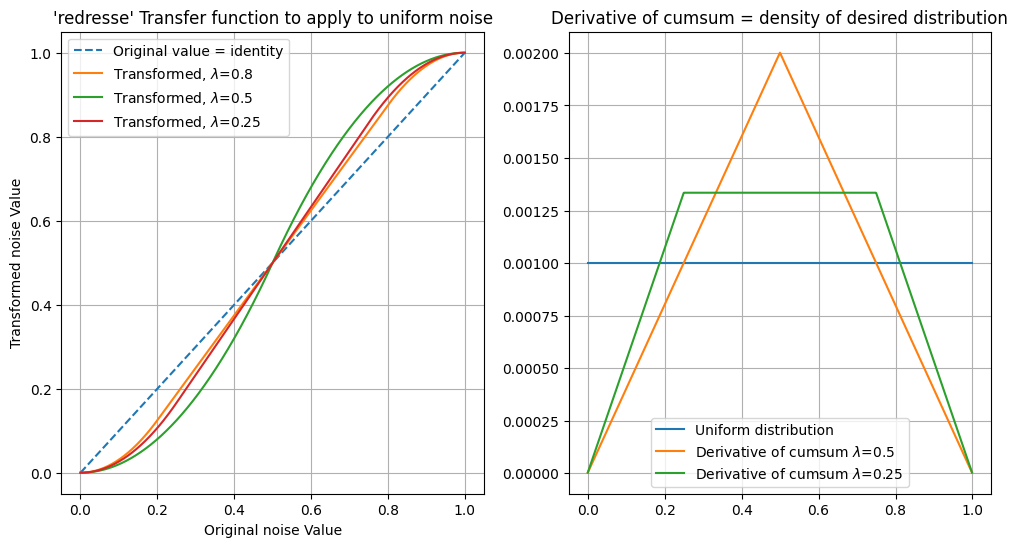

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def redresse(t, trans=False, lam=0.5):
    if lam > 1 - lam:
        lam = 1 - lam
    if (not trans) or (lam < 0.01):
        return t
    else:
        c = 1 / 2 * (lam) / (1 - lam)
        mask0 = t > 1 / 2
        t[mask0] = 1 - t[mask0]
        mask = (t <= lam)
        t[mask] = 1 / 2 * (1 / (1 - lam)) * (1 / lam) * t[mask] ** 2
        mask = (t > lam) * (t < 1 / 2)
        t[mask] = c + (1 / (1 - lam)) * (t[mask] - lam)
        t[mask0] = 1 - t[mask0]
    return t

# Generate a sample texture (1D for simplicity)
myt = np.linspace(0., 1., num=1000)

# Apply the transformation with different settings
t_trans_true_lam_0_8 = redresse(myt.copy(), trans=True, lam=0.8)
t_trans_true_lam_05 = redresse(myt.copy(), trans=True, lam=0.5)
t_trans_true_lam_025 = redresse(myt.copy(), trans=True, lam=0.25)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(myt, myt, label="Original value = identity", linestyle='--')
plt.plot(myt, t_trans_true_lam_0_8, label="Transformed, $\lambda$=0.8")
plt.plot(myt, t_trans_true_lam_05, label="Transformed, $\lambda$=0.5")
plt.plot(myt, t_trans_true_lam_025, label="Transformed, $\lambda$=0.25")

plt.title("'redresse' Transfer function to apply to uniform noise")
plt.xlabel("Original noise Value")
plt.ylabel("Transformed noise Value")
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(myt[:-1], np.ones_like(myt[:-1])/len(myt[:-1]),label="Uniform distribution")
plt.plot(myt[:-1], np.diff(t_trans_true_lam_05), label="Derivative of cumsum $\lambda$=0.5")
plt.plot(myt[:-1], np.diff(t_trans_true_lam_025),label="Derivative of cumsum $\lambda$=0.25")
plt.grid()
plt.legend()
plt.title("Derivative of cumsum = density of desired distribution")
plt.show()
